In [1]:
import pandas as pd
from app import db
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Welcome!

We're going to try to predict a user's next request using their last few requests.

In [3]:
df = pd.read_sql('access_log', db.engine, index_col='id')

In [4]:
df = df[['user_id', 'time', 'key', 'value']]

In [5]:
df = df.assign(count_by_user=df.assign(val=1).groupby('user_id').agg({'val': 'cumsum'})).reset_index()

In [6]:
df = df.set_index(['user_id', 'count_by_user']).sort_index()

In [7]:
enhanced_df = df.assign(
    prev_key=df['key'].shift(1),
    prev_value=df['value'].shift(1),
    two_keys_ago=df['key'].shift(2),
    two_values_ago=df['value'].shift(2),
    diff_key=df['key'].diff(),
)
# Also set first of each user's actions to -1
enhanced_df.loc[pd.IndexSlice[:, [1]], ['prev_key', 'prev_value', 'diff_key']] = np.nan
enhanced_df.loc[pd.IndexSlice[:, [1, 2]], ['two_keys_ago', 'two_values_ago']] = np.nan

enhanced_df = enhanced_df.assign(
    ratio_key=enhanced_df['key'] / enhanced_df['prev_key'],
    time_seconds=(enhanced_df['time'] - enhanced_df['time'].min()).dt.seconds,
)
enhanced_df =  enhanced_df.assign(
#     mult=((enhanced_df['ratio_key'] * enhanced_df['key']) % 1e6).astype(int),
#     summer=((enhanced_df['key'] + enhanced_df['diff_key']) % 1e6).astype(int),
    seconds_since_last=enhanced_df['time_seconds'] - enhanced_df['time_seconds'].shift(1),
)
enhanced_df.loc[(enhanced_df.ratio_key < 0), ['ratio_key', ]] = np.nan
enhanced_df.loc[pd.IndexSlice[:, [1]], 'seconds_since_last'] = np.nan
enhanced_df = enhanced_df.reset_index()


In [8]:
target = pd.concat([
    df['key'].shift(-1).rename('next_key'),
    (df['key'].shift(-1) - df['key']).rename('delta_key'),
    (df['key'].shift(-1) / df['key']).round(5).rename('next_ratio_key'),
    -(df['key'].shift(-1) - 1e6).rename('key_wrap'),
    ((df['key'].shift(-1) - 1e6) / -df['key']).rename('ratio_wrap'),
    df['time']
], axis=1)
target.loc[pd.IndexSlice[:, [10]], ['delta_key', 'next_key', 'next_ratio_key']] = np.nan
target = target.reset_index(drop=True)

In [9]:
cutoff = enhanced_df.time.quantile(.7)
mask = (~(target.drop('time', axis=1).isnull()).any(axis=1))
X = enhanced_df.loc[mask]
train_df = X.loc[(enhanced_df.time <= cutoff)].drop(['time', 'count_by_user'], axis=1)
test_df = X.loc[(enhanced_df.time > cutoff)].drop(['time', 'count_by_user'], axis=1)
Y = target.loc[(mask)]
train_y = Y.loc[(target.time <= cutoff)]['delta_key']
test_y = Y.loc[(target.time > cutoff)]['delta_key']

In [10]:
import lightgbm as lgb
ds = lgb.Dataset(train_df, label=train_y, free_raw_data=False)
valid = lgb.Dataset(test_df, label=test_y, free_raw_data=False)

Use MAPE in order to make sure the median percentage error is minimized, so that a lot of cases have 0 error (cache needs to have an actual hit rather than an approximate one!)

In [11]:
%%time
params = {
    'objective': 'mape',
    'num_boost_round': 100,
    'early_stopping_rounds': 30,
    'learning_rate': 0.1,
    'num_leaves': 12,
    'min_data_in_leaf': 50,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'bagging_fraction': 0.2,
    'feature_fraction': 0.2,
    'metric': ['mape']
}
naive = lgb.train(params, ds, valid_sets=valid, verbose_eval=False)

/Users/johnurbanik/prescient/env/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/johnurbanik/prescient/env/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 2min 53s, sys: 17 s, total: 3min 10s
Wall time: 20.9 s


In [12]:
naive_pred = pd.Series(naive.predict(X.drop(['time', 'count_by_user'], axis=1).astype(float)), index=X.index)

In [13]:
(np.round(naive_pred) == Y['delta_key']).sum() / X.shape[0]

0.19535333333333332

We can totally do better than 20% matching, right? Otherwise this is not worth it. We could probably do something with a stacked model of a few different objectives, but lets try some more clever stuff and see if we can make it more robust than that.

In [14]:
from sklearn.cluster import Birch, DBSCAN
from sklearn.preprocessing import StandardScaler

Let's try hierarchical clustering, and then afterwards address these clusters individually.

In [15]:
global_view = pd.concat([X, Y], axis=1)

In [16]:
%%time
import umap
c_ = global_view.drop('time',axis=1).dropna(how='any').assign(
    div_2=global_view.key % 2 == 0,
    div_3=global_view.key % 3 == 0,
    div_not=(global_view.key % 2 != 0) & (global_view.key % 3 != 0),
    wrap_around=-(global_view.delta_key - 1e6),
)
cd = c_.sample(20000)

embedder = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, metric='correlation').fit(cd)

CPU times: user 40.7 s, sys: 1.06 s, total: 41.7 s
Wall time: 16.1 s


In [17]:
%%time
import hdbscan
cr = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, prediction_data=True)

labels = cr.fit_predict(embedder.transform(cd))

CPU times: user 481 ms, sys: 108 ms, total: 588 ms
Wall time: 1.21 s


In [18]:
%%time
full_embedding = embedder.transform(c_)
full_labels = hdbscan.approximate_predict(cr, full_embedding)

CPU times: user 4min 6s, sys: 1.98 s, total: 4min 8s
Wall time: 1min 33s


In [19]:
def draw_umap(u, n_components=2, c=None):
    fig = plt.figure()
    if not c:
        c=data
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=c)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=c)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=c, s=2, alpha=0.25)

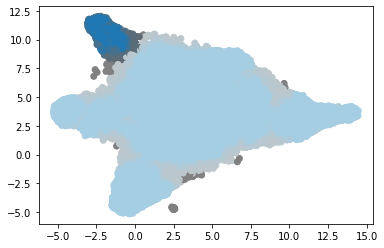

In [20]:
color_palette = sns.color_palette('Paired', len(np.unique(cr.labels_)))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in full_labels[0]]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, full_labels[1])]
draw_umap(full_embedding, 2, cluster_member_colors)

In [21]:
panel = pd.concat([c_,pd.Series(full_labels[0],name='cluster', index=c_.index)], axis=1).groupby('cluster').agg(['median', 'std'])

In [22]:
panel.T

cluster                          -1         0            1
user_id            median     50001     49984      50242.5
                   std      29726.1   28864.4      28915.8
count_by_user      median         8         6            5
                   std      1.72946   1.99553      1.86031
id                 median    553484    503688       490121
                   std       301997    288703       285283
key                median        70     55358       516432
                   std      79304.9    147978       248295
value              median    619621    502115       500761
                   std       275927    288588       286832
prev_key           median       210     81245       429339
                   std      73750.8    208816       226146
prev_value         median    578426    502156       492905
                   std       255201    288474       287554
two_keys_ago       median       486    116493       392534
                   std       113290    259708       208047
two_values_ago     median    458274    500840       507054
                   std       278687    288484       287740
diff_key           median      -120         7        76471
                   std      21555.3    153455      57202.7
ratio_key          median  0.333333   1.00014          1.2
                   std      0.29587   186.737      656.307
time_seconds       median    5821.5      5330       5194.5
                   std      3026.57   2890.74      2856.35
seconds_since_last median        60        60           60
                   std            0         0            0
next_key           median    747208   40143.5       145412
                   std       253932    168350      85531.9
delta_key          median    747158         7      -343259
                   std       320273   53820.6       229890
next_ratio_key     median   11085.2   1.00219      0.33333
                   std      6227.87    133.62     0.144696
key_wrap           median    252792    959856       854588
                   std       253932    168350      85531.9
ratio_wrap         median   2520.32   17.2046      1.55973
                   std      2520.85    535.63     0.966456
div_2              median      True      True         True
                   std      0.49058   0.47295     0.492665
div_3              median     False     False         True
                   std     0.470057  0.469197     0.393511
div_not            median     False     False        False
                   std     0.414446  0.390198     0.111997
wrap_around        median    252842    999993  1.34326e+06
                   std       320273   53820.6       229890

In [23]:
%%time
birch = Birch(n_clusters=None)
birch.partial_fit(embedder.transform(cd))

CPU times: user 909 ms, sys: 50.7 ms, total: 960 ms
Wall time: 736 ms


Birch(n_clusters=None)

In [24]:
%%time
birch.set_params(n_clusters=20) # Should capture a few different behaviors
birch.partial_fit()
birchy = birch.predict(full_embedding)

CPU times: user 2.03 s, sys: 2.62 s, total: 4.65 s
Wall time: 1.22 s


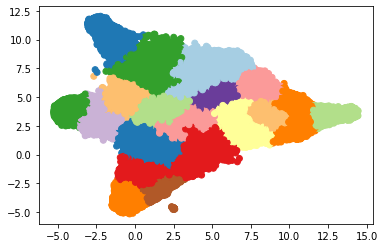

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
color_palette = sns.color_palette('Paired', len(np.unique(birchy)))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in birchy]
draw_umap(full_embedding, 2, cluster_colors)

In [26]:
panel2 = pd.concat([c_,pd.Series(birchy,name='cluster', index=c_.index)], axis=1).groupby('cluster').agg(['median', 'std'])

In [27]:
panel2.T

cluster                          0         1         2         3         4   \
user_id            median     50436     49675     50483     50073     50105   
                   std      28768.7   28852.8   28761.1   28800.8   28871.8   
count_by_user      median         7         7         7         7         7   
                   std      1.82932   1.83862   1.82908    1.8272   1.83569   
id                 median    287140    751750    229230    220141    456255   
                   std       176007    178530    181171    165559    202199   
key                median   29171.5   33317.5     29389     30040     30184   
                   std      47721.2   56594.5   50448.8   50828.7   48700.6   
value              median    763628    228294    582966    337332    506204   
                   std       194143    174161    284956    268813    257329   
prev_key           median     40606     45224     41612     41946     42318   
                   std      53989.4   53575.8     51779   54946.3   50039.6   
prev_value         median    266114    783338    802570    396103    690698   
                   std       187625    163403    150929    227390    181371   
two_keys_ago       median   60297.5     66878     61622     62067     62880   
                   std      93812.4    111491   94481.5   89321.6    102989   
two_values_ago     median    648285    719975    408324    785200    321687   
                   std       201767    190119    263101    164091    250279   
diff_key           median         7         7         7         7         7   
                   std      37332.1   32722.4   34070.6   37288.7   33372.8   
ratio_key          median   1.00038   1.00059   1.00039   1.00039   1.00038   
                   std        52.85   79.5454    59.633   52.4896   53.6731   
time_seconds       median      3146      7787      2571      2480      4853   
                   std      1765.34   1787.58   1815.68   1661.09   2023.26   
seconds_since_last median        60        60        60        60        60   
                   std            0         0         0         0         0   
next_key           median   19924.5     24301     20565     20732     20601   
                   std      45020.1     58544   48776.8   44100.9   44782.4   
delta_key          median         7         7         7         7         7   
                   std      29429.2     32256   30678.5   33069.4     31313   
next_ratio_key     median   1.00069   1.00147   1.00085   1.00061   1.00043   
                   std      44.5676   125.558   104.832   65.2244   79.1851   
key_wrap           median    980076    975699    979435    979268    979399   
                   std      45020.1     58544   48776.8   44100.9   44782.4   
ratio_wrap         median   33.3312   29.1214   33.2147   32.4525   32.3016   
                   std      609.361   633.993   646.926   590.056   633.066   
div_2              median      True      True      True      True      True   
                   std     0.476775  0.472115  0.474901  0.476645  0.477775   
div_3              median     False     False     False     False     False   
                   std     0.483708  0.474141  0.480429  0.485093  0.487626   
div_not            median     False     False     False     False     False   
                   std     0.384722  0.390859  0.386102    0.3809  0.386145   
wrap_around        median    999993    999993    999993    999993    999993   
                   std      29429.2     32256   30678.5   33069.4     31313   

cluster                          5         6          7         8         9   \
user_id            median     49554     50271      49723     49689   49413.5   
                   std        28872   28704.1    28825.1   28863.8   28889.4   
count_by_user      median         7         6          5         4         7   
                   std      1.83099   1.95319    1.85545   1.56134   1.84504   
id                 median    745566    18326

Unforunately, these clustering methods don't seem to recover clean clusters; there is a ton of variance in most of the variables.

The same is true with pure HDBSCAN and other clustering methods - guess we'll have to try a different approach to capturing these behaviors!

### Let's do some symbolic regression through genetic programming!

We probably want to add coevolution via something like DEAP, or just use featuretools and don't worry about validating.

For now, lets define a fitness function that is mostly smooth, MAE but with no error when you're within rounding range.

In [28]:
from gplearn import genetic
from gplearn import functions, fitness

In [29]:
def _correct_pct(y, y_pred, w):
    return np.average((np.abs(y_pred.round() - y) > 0)) #* np.abs(y_pred - y)/np.abs(y))

correct_pct = fitness.make_fitness(_correct_pct, greater_is_better=False)

Build a function library, starting with some very basic functions of a small set of features. We can expand the features once we have a better methodology, but we know apriori that just key is sufficient for our program.

In [30]:
divisible_by = functions.make_function(lambda x, y: np.where(y == 0, 0, 1*(x % y.astype(int) == 0)), name='divisible_by', arity=2)
where_true = functions.make_function(lambda x, y, z: np.where(x == 1, y, z), name='where_true', arity=3)
where_divisible_by = functions.make_function(lambda w, x, y, z: np.where(x == 0, 0, np.where((np.round(w) % np.round(x) == 0), y, z)), name='hh', arity=4)
around_town = functions.make_function(lambda x, y: np.where(x < 0, x, y), name='around', arity=2)
where_less = functions.make_function(lambda w, x, y, z: np.where(w < x, y, z), name='where_less', arity=4)
where_equal = functions.make_function(lambda w, x, y, z: np.where(w == x, y, z), name='where_equal', arity=4)
greater_of = functions.make_function(lambda x, y: np.where(x < y, y, x), name='greater_of', arity=2)
roundy = functions.make_function(lambda x: x.round(), name='round', arity=1)
sub_cap = functions.make_function(lambda x: x - 1e6, name='sub_cap', arity=1)

In [31]:
gene_df = train_df.dropna(how='any').sample(n=np.minimum(10000, X.shape[0]))[['key']].assign(a=1.2, b=3, c=7)

In [32]:
library = []
uncoded = gene_df.copy()
staleness = 0
while len(uncoded) > 1000 & staleness < 10:    
    est_gp = genetic.SymbolicRegressor(
        population_size=2000,
        tournament_size=20,
        generations=20, stopping_criteria=.1,
        p_crossover=0.1, p_subtree_mutation=0.1,
        p_hoist_mutation=0.01, p_point_mutation=0.1,
        p_point_replace=0.05,
        const_range=(3, 5),
        max_samples=1, verbose=1,
        init_depth=(5,7), n_jobs=4,
        feature_names=gene_df.columns,
        function_set=[roundy, where_divisible_by, 'mul', 'div'],
#         function_set=[roundy, divisible_by, where_true, where_divisible_by, 'mul', 'div'],#, 'mul', 'add', 'div', 'neg',],
        metric=correct_pct, low_memory=True,
        parsimony_coefficient=0.0001, random_state=np.random.randint(0,1e6)
    )
    yhat = Y.loc[uncoded.index].drop('time', axis=1)['next_key']
    res = est_gp.fit(uncoded, yhat)
    prev = len(uncoded)
    temp = uncoded.loc[np.abs(res.predict(uncoded) - yhat) > 0].dropna(how='any')
    print('.', end='')
    if prev - len(temp) > 100:
        uncoded = temp
        print(prev, len(uncoded))
        library = library + [res._program]
        staleness = 0
    else:
        staleness = staleness + 1

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   160.81          0.99779       24           0.6473              N/A      1.19m
   1     9.65         0.965829        4           0.6473              N/A     14.48s
   2    22.45         0.764802        4           0.6473              N/A     17.29s
   3     6.15         0.698588        4           0.6473              N/A     18.45s


/Users/johnurbanik/prescient/env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   4     3.69         0.696542        3           0.6473              N/A     28.60s
   5     3.55         0.695294        3           0.6473              N/A     20.64s
   6     3.48         0.694738        3           0.6473              N/A     10.78s
   7     3.87         0.696278        3           0.6473              N/A      9.55s
   8     3.50         0.697324        3           0.6473              N/A      9.19s
   9     3.87         0.692608        3           0.6473              N/A      8.45s
  10     4.24         0.694385        3           0.6473              N/A      7.55s
  11     3.45         0.699893        3           0.6473              N/A      6.53s
  12     3.63         0.698346        3           0.6473              N/A      6.15s
  13     3.50         0.693938        3           0.6473              N/A      8.47s
  14     3.82         0.694643        3           0.6473              N/A      4.20s
  15     3.68         0.696664        3           0.6473         

/Users/johnurbanik/prescient/env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   3     5.89         0.728652        6         0.672513              N/A     22.67s
   4     3.75         0.716887        3         0.672513              N/A     13.34s
   5     4.23           0.7206        3         0.672513              N/A     12.85s
   6     3.59         0.714267        3         0.672513              N/A      9.17s
   7     3.65         0.718876        3         0.672513              N/A      8.83s
   8     3.51          0.71787        3         0.672513              N/A      8.16s
   9     3.52         0.715741        3         0.672513              N/A     14.00s
  10     3.72         0.718043        3         0.672513              N/A     13.44s
  11     3.35         0.713121        3         0.672513              N/A      5.86s
  12     3.83         0.723601        3         0.672513              N/A      8.93s
  13     3.65         0.719179        3         0.672513              N/A      4.56s
  14     3.81         0.718197        3         0.672513         

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6)}

We're having issues with a memory leak in GPLearn. Up next, DEAP or potentially Julia!

In [40]:
print(res._program)

div(key, b)


In [41]:
for prog in library:
    print(prog)

div(key, b)


In [42]:
print(res._program)

div(key, b)
